In [6]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt

import json

In [7]:
chunksize = 10 ** 4
filepath = "data/2022_place_history_sorted.csv"

ddf = dd.read_csv(filepath)
ddf

,timestamp,user_id,pixel_color,coordinate
npartitions=341,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [8]:
part = ddf.partitions[-7]
part["timestamp"] = dd.to_datetime(part["timestamp"])
# part.sort_values(by=["timestamp"], ascending=True)
part.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469837 entries, 0 to 469836
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   timestamp    469837 non-null  datetime64[ns, UTC]
 1   user_id      469837 non-null  object             
 2   pixel_color  469837 non-null  object             
 3   coordinate   469837 non-null  object             
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 14.3+ MB


In [9]:
timestamp_idx = 1
user_id_idx = 2

threshold = 0.2 # in seconds

count_dict = {}
variance_dict = {}
time_since_dict = {}
last_pixel_time_dict = {}

for row in part.itertuples():
    user_id = row[user_id_idx]
    if user_id in last_pixel_time_dict.keys():
        if user_id in time_since_dict.keys():
            time_since_last_pixel = row[timestamp_idx] - last_pixel_time_dict[row[user_id_idx]]
            variance = abs((time_since_dict[user_id] - time_since_last_pixel).total_seconds())
            if variance < threshold:
                if user_id not in count_dict.keys():
                    count_dict[user_id] = 0
                count_dict[user_id] += 1
            else:
                time_since_dict[user_id] = time_since_last_pixel
        else:
            time_since_dict[user_id] = row[timestamp_idx] - last_pixel_time_dict[user_id]
    last_pixel_time_dict[user_id] = row[timestamp_idx]


In [10]:
timestamp_idx = 1
user_id_idx = 2

threshold = 0.5 # in seconds

count_dict = {}
variance_dict = {}
time_since_dict = {}
last_pixel_time_dict = {}

for partit in ddf.partitions:
    partit["timestamp"] = dd.to_datetime(partit["timestamp"])
    for row in partit.itertuples():
        user_id = row[user_id_idx]
        if user_id in last_pixel_time_dict.keys():
            if user_id in time_since_dict.keys():
                time_since_last_pixel = row[timestamp_idx] - last_pixel_time_dict[row[user_id_idx]]
                variance = abs((time_since_dict[user_id] - time_since_last_pixel).total_seconds())
                if variance < threshold:
                    if user_id not in count_dict.keys():
                        count_dict[user_id] = 0
                    count_dict[user_id] += 1
                else:
                    time_since_dict[user_id] = time_since_last_pixel
            else:
                time_since_dict[user_id] = row[timestamp_idx] - last_pixel_time_dict[user_id]
        last_pixel_time_dict[user_id] = row[timestamp_idx]


In [11]:
with open('counts.txt', 'w') as convert_file:
    convert_file.write(json.dumps(count_dict))

In [12]:
count_series = pd.Series(count_dict)
count_series.sort_values(ascending=False)

fKNBueWS8c3w3vtqClU1+1QRi4qjHXOmX5aWta7QvKQj5aB6evQwiq2s8Lg6GV9rZcKjENT7+mNQE5AJXJGSBQ==    390
qqjD4zYwKS6FrxRkJfHKmxDEtFMEJ3ETGYYyMyNEE+2i9ul3WiqZ2glOks749PNfRdIeMbjz08yVEGEiVGs7gw==    370
j64pL7yMe8HJqMz2IieaA51yhh5r7tj3CVAdRl0iNJJG3W4CZR76ykdilpSxeIoULLVx5tWRksxLfxEhTH4O1A==    360
0mrF6+rh/QJKPf8UBjlOGrCVm+Xa/+V8erJyHcRGaqgb/VpnrF+eOHvxKWD5LahBRkN0IVRMNffEoyFkidcJKA==    356
TwvGv5iDGt6GKM94Y4L49H1G01PxJsJaOMdXxxAnL8vMP+5aB5pUNkN8GQ2wJ6xOJDep5PVC4rAzYN/b++GuOQ==    355
                                                                                           ... 
zmyt0uJQWt7mf85sa38gbOfroRDd2U1fhnymCucN2cYi5pxPCR3r1s864JM14x4J8NJeqPQS6JKs7QH+APsc0g==      1
4Ll9ea5U3lfOCbdbaehFGrlk+0zY5d+3zylw0n1lGktdsnXpcaztGTQJQtIfgha6MGV8Di3xuPkjxliyWSwQBQ==      1
LJwYyBoObDlSWdEZKDCtJjRhnVBaZgtrIOv5IBar0/Sj4ggh0CCsF47XkDudo9e+kN07bPc+vh/YYgqR3VX19w==      1
QY8jdxP220YagxLRML0gdL+2JjdjSS8Ys0PRM7C1vXxDAIFKe7OXtmYpZhDqFb4AWbUw8Ge9FC2xpUfPLkPPdg==      1
hDfLz5bUNCes/zWRcMn8WUX9PKadpuMjef0aTPhi

In [13]:
with open('user_ids.txt', 'w') as outfile:
    json.dump(list(count_dict.keys()), outfile)

(array([7.76896e+05, 4.60600e+03, 1.50700e+03, 5.09000e+02, 1.74000e+02,
        8.20000e+01, 2.70000e+01, 2.00000e+01, 8.00000e+00, 6.00000e+00]),
 array([  1. ,  39.9,  78.8, 117.7, 156.6, 195.5, 234.4, 273.3, 312.2,
        351.1, 390. ]),
 <BarContainer object of 10 artists>)

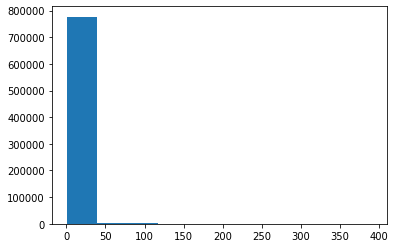

In [14]:
plt.hist(count_series)

(array([2.2132e+04, 3.3930e+03, 1.1700e+03, 4.1700e+02, 1.4500e+02,
        8.0000e+01, 2.5000e+01, 1.7000e+01, 7.0000e+00, 6.0000e+00]),
 array([ 11. ,  48.9,  86.8, 124.7, 162.6, 200.5, 238.4, 276.3, 314.2,
        352.1, 390. ]),
 <BarContainer object of 10 artists>)

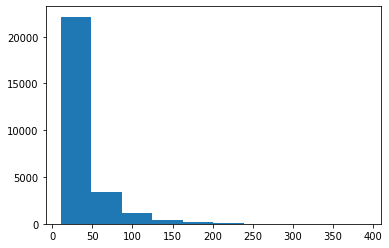

In [15]:
plt.hist(count_series.where(count_series > 10))

In [16]:
count_series[count_series > 2]

T0YpbXSKH34JeN7b4+TKC53JGM1FAfstI51tt1qGIbrPvsQscxzGVtnGaAYesxhXTMh32obx4np8uD937IqKEA==    9
kBX00zaCBoA3r+p1A1TZ26I7xXbZ6mt4IrHJguitBN+IJAqhafZK4d0zdl55SoWivocPOPygxHDgpoICFfu+zg==    3
jjwH3WEsSqbeoJz9OCQiutoCF019SuuosvSroMVPc1mA5N6mUh04deJWKlVovmXN3ZdwJD7naG94TU/CdwYufw==    3
+gXsJwMEEBWw0BQjq5K70b61RrUXtiQ3CZTNw0rMNTMLafOv9OyQkDX+SHYwHmCuqrhSeHTT0+276VKFtxVzXQ==    3
fBfvmRbm9SEB4VV/sN/cNTEVvdtN0rGa83cW8r6M5HwFZsbYneX9abBUjYNXEKZqZsVqW8fVpzvejfd6pV0pcQ==    7
                                                                                           ..
71XjiILw3dWHNKYIZfBkgwCkZIw+lr33RXfe6TvOLQR4EyeUSRD8w5q+BiYDp67uJzKsezFFvz/Ivfk/oVvUSA==    3
/gJYMMYpiuc1/h781TdzoyP2WDUqkHVoUvTUZNlXo4nV+P5+XqIihnzi83gDxUx2VYR2t21Pp5SQktqCtggyYg==    3
9JBui46OVhbcE9jnsC/7nblT8ldQeRcARDjOZs4wVQBXSRDJrcattdISWBXPVbc+CHRBoKxclwRR3WV2lyrbdQ==    3
UCqOot736llEXhBf45WGn0TuPgysb99Nac39R7BCIJyN1+Li7mGu/0900pTkf2dHkPXcCdys3nTVYt+178bQZg==    3
NBp9JUeoTT30rO26fLvsb5D3BylBSFZ6uZKAbk18wOI+kOiVFPOlOhXFMI12

In [19]:
count_series[count_series > 10]

P0roP7FJ7BIv+pxYxccv6LjyWWgFJL2oblWikeN+tsUrBY6beN8UU5OAiixj7aqqLFdQZoEhLPDiwf5dlARdkA==    30
ahuJK+u6rQxGhEkKMDUp+iRzzXsfSGV4MTeBDyNr7m3Tyk3kLYwSHLI+eVSFZ4tt7tdvy/+HLSUZwCrIMLdXMQ==    12
mRJwZGFshD6TFCdqfM5CV1ZF4fXyfS8O2ndhc6HeN0Sk81q3bf37IRP8O53HyPOWNdFerii57scS4x84oyxZyg==    15
BGS7bLBYFpJ5x9J2glzMbODxxUwpGNbmPBZ1mq9T9QfnF2CPlTt09/N04mvzgl96SLIlQksp2OpviYdeRNunNw==    11
WmS3XPfSWnPVCCw50uBi9llRXILVWlH+9dHyE+h7MEGJWouTXWMkFYkjuGItAQNFGR40ZI5EfmdUS0WBQxdKLg==    13
                                                                                            ..
/l2bNVtsZ136bI0BxVov4wk/hxYmKrUZ+4zA9YhSsEjXDiON5GnpkQjhtD3CqploUDvdb9eAxAvDPvm+i1nllA==    13
X50sX2aibw66aSmQA+jrUMrUqKVvAYAfoxbgjK38rRxallK1wIwxJHsQLXzypcrvWB7gk2JgI9Rm+qodiCsZ5w==    11
5L9X4dnfSJe3QMJuweeMC1CYd0hPw6nCzitX37fG0LtXaN92VZs2kZAwEsOKVGbrJOHjlIQUV59cdCPvAhN/8w==    11
hAp8Xirufh6p13vk6GWeU2L8gFYx7F4jWrSyaCPJz3TAF3bCUFikGTiyENDWOUcN6VfyGIlcMvGhUHBXa3Xr1A==    11
tfW2pX4opsc8noHa5b0X24BEz25RdqkGIABG7rwAK3CVaYelxA

In [17]:
with open('counts_greater_than_2.txt', 'w') as convert_file:
    convert_file.write(json.dumps(count_series[count_series > 2].to_dict()))

In [18]:
with open('user_ids_greater_than_2.txt', 'w') as outfile:
    json.dump(list(count_series[count_series > 2].to_dict().keys()), outfile)